1. Load required packages

In [38]:
import warnings
import calmap
import pickle
import random
import time
import os
from plotly_calplot import calplot
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from yellowbrick.target import ClassBalance
from yellowbrick.target import class_balance
from sklearn import tree
from xgboost import XGBClassifier,plot_importance
from IPython.display import Image

warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

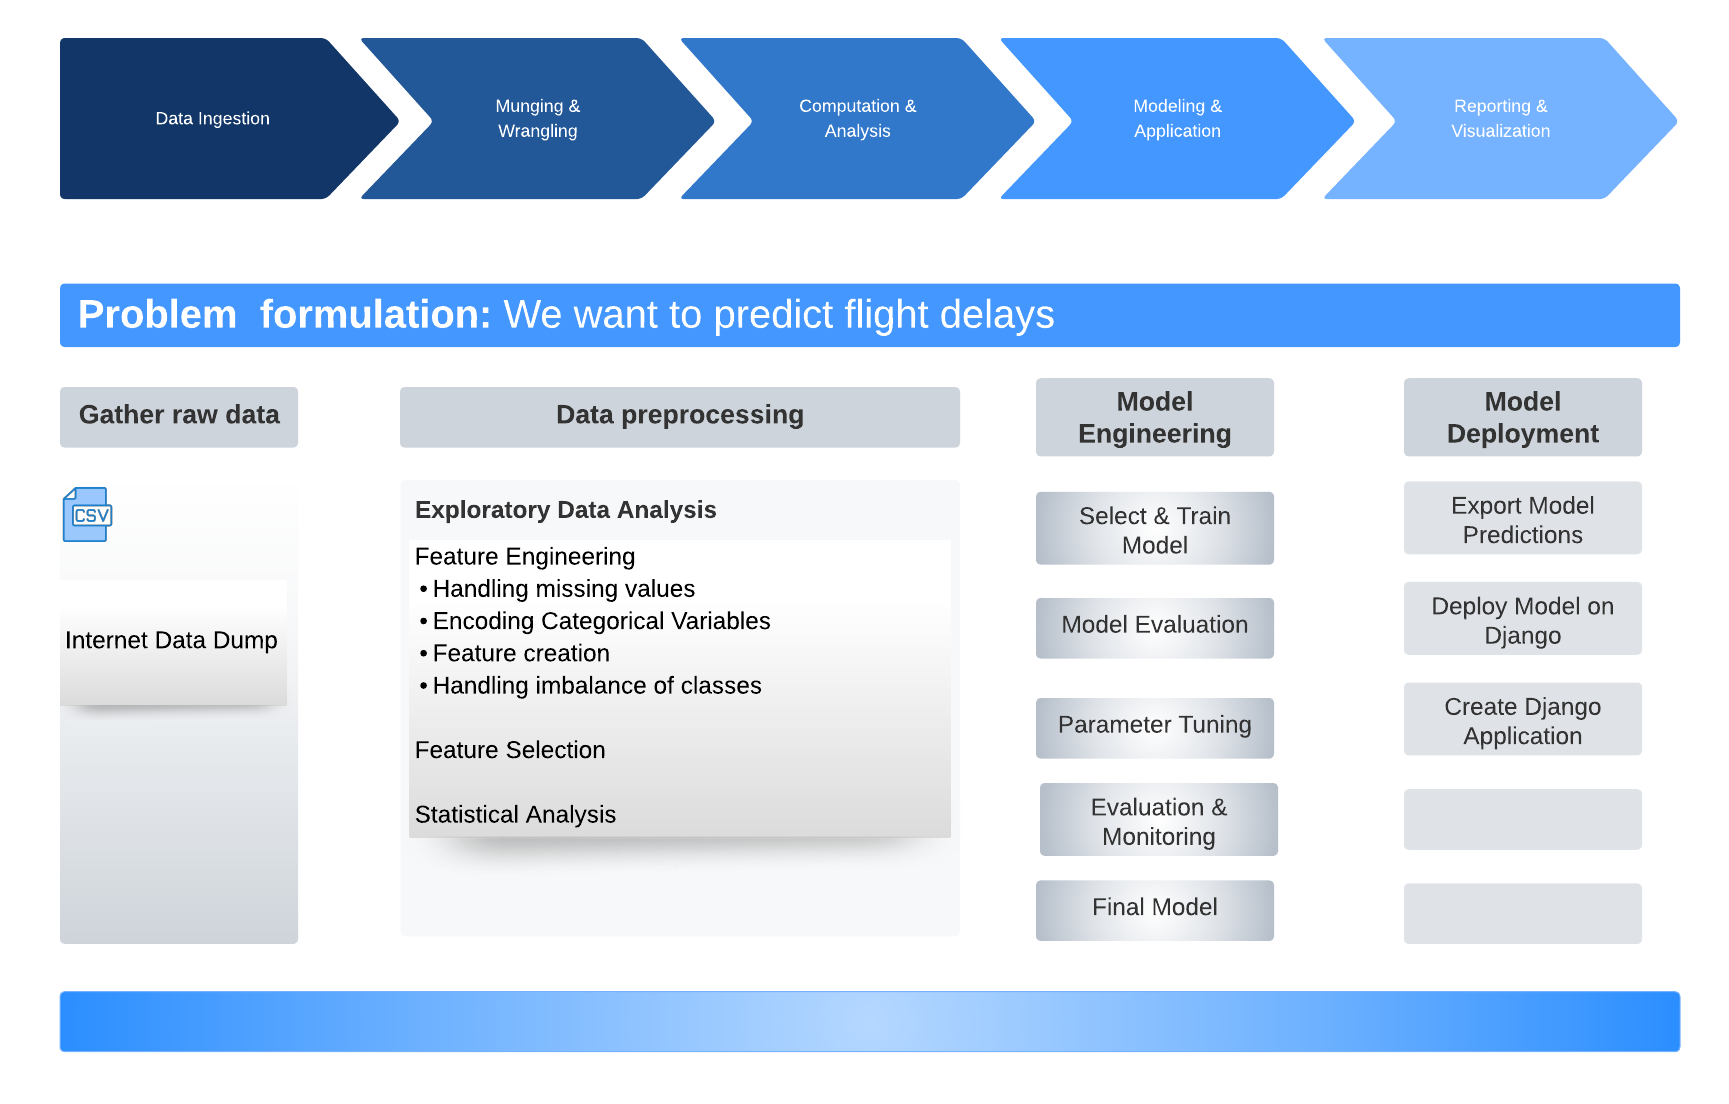

In [3]:
Image("../../../data/images/MLProcess.png")

### Load in the data

In [4]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../../data/eda/flights/all_flight_data_20182019_20212022/all_flight_data_20182022NC.zip",skiprows=skip, low_memory=False, encoding="iso-8859-1")

In [5]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [6]:
airlines = pd.read_csv(
    "../../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [7]:
cancellation_codes = pd.read_csv(
    "../../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [8]:
usa_airports = (pd.read_csv("../../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



In [9]:
df_flights.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,95,2018,1,1,6,6,2018-01-06,DL,DL_CODESHARE,19790,DL,3300,NaN,NaN,NaN,NaN,9E,20363,9E,N8986B,3300,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,15096,1509602,35096,SYR,"Syracuse, NY",NY,36,New York,22,1810,1805.0,-5.0,0.0,0.0,-1.0,1800-1859,20.0,1825.0,1907.0,6.0,1928,1913.0,-15.0,0.0,0.0,-1.0,1900-1959,0.0,NaN,0.0,78.0,68.0,42.0,1.0,198.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,147,2018,1,1,28,7,2018-01-28,DL,DL_CODESHARE,19790,DL,3301,NaN,NaN,NaN,NaN,9E,20363,9E,N8969A,3301,11617,1161708,31617,EWN,"New Bern/Morehead/Beaufort, NC",NC,37,North Carolina,36,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1415,1516.0,61.0,61.0,1.0,4.0,1400-1459,12.0,1528.0,1648.0,11.0,1605,1659.0,54.0,54.0,1.0,3.0,1600-1659,0.0,NaN,0.0,110.0,103.0,80.0,1.0,433.0,2,1.0,0.0,0.0,0.0,53.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,158,2018,1,1,4,4,2018-01-04,DL,DL_CODESHARE,19790,DL,3302,NaN,NaN,NaN,NaN,9E,20363,9E,N836AY,3302,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,11641,1164102,31641,FAY,"Fayetteville, NC",NC,37,North Carolina,36,1714,1709.0,-5.0,0.0,0.0,-1.0,1700-1759,13.0,1722.0,1811.0,8.0,1834,1819.0,-15.0,0.0,0.0,-1.0,1800-1859,0.0,NaN,0.0,80.0,70.0,49.0,1.0,331.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,242,2018,1,1,28,7,2018-01-28,DL,DL_CODESHARE,19790,DL,3303,NaN,NaN,NaN,NaN,9E,20363,9E,N176PQ,3303,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,37,North Carolina,36,10721,1072102,30721,BOS,"Boston, MA",MA,25,Massachusetts,13,1420,1416.0,-4.0,0.0,0.0,-1.0,1400-1459,20.0,1436.0,1606.0,10.0,1619,1616.0,-3.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,119.0,120.0,90.0,1.0,612.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
  - Feature creation
  - Handling of imbalanced classes in dataset
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [10]:
#df_flights.dtypes

In [11]:
df_flights.dtypes

Unnamed: 0                                   int64
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
FlightDate                                  object
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
DOT_ID_Marketing_Airline                     int64
                                            ...   
Div5Airport                                float64
Div5AirportID                              float64
Div5AirportSeqID                           float64
Div5WheelsOn                               float64
Div5TotalGTime                             float64
Div5LongestGTime                           float64
Div5WheelsOff                              float64
Div5TailNum                                float64
Duplicate                      

In [12]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 0.5, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 0.5), "DepDelayClass"] = "Delayed"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Delayed"
    return df_flights

def tweak_df_flights(df_flights):
    DepDelay_Class(df_flights)
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime","DepDelayClass"
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "int16",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16",
            "DepDelayClass": "category"
        }
    )


df_flights = tweak_df_flights(df_flights)

print(df_flights.shape)
df_flights.tail()


(619568, 44)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude
619563,2022-08-11,Comair Inc.,N602NN,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1842.0,29.0,1.0,29.0,1800-1859,20.0,1901.0,5.0,1844,1906.0,22.0,1.0,1800-1859,0,none,False,91.0,59.0,333.0,12.0,0.0,0.0,0.0,10.0,0.0,0.0,Delayed,35.21875,-80.9375
619564,2022-08-04,Comair Inc.,N610NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,837,935.0,58.0,1.0,58.0,0800-0859,14.0,1039.0,9.0,958,1048.0,50.0,1.0,0900-0959,0,none,False,81.0,50.0,319.0,50.0,0.0,0.0,0.0,0.0,832.0,26.0,Delayed,38.84375,-77.0625
619565,2022-08-25,Comair Inc.,N571NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,825.0,-9.0,0.0,0.0,0800-0859,25.0,951.0,8.0,1006,959.0,0.0,0.0,1000-1059,0,none,False,92.0,61.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625
619566,2022-08-18,Comair Inc.,N563NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,742,735.0,-7.0,0.0,0.0,0700-0759,20.0,911.0,3.0,931,914.0,0.0,0.0,0900-0959,0,none,False,109.0,76.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625
619567,2022-08-12,Comair Inc.,N501BG,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1714,1742.0,28.0,1.0,28.0,1700-1759,18.0,1919.0,13.0,1905,1932.0,27.0,1.0,1900-1959,0,none,False,111.0,79.0,524.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,38.84375,-77.0625


In [13]:
#df_flights.describe()

In [14]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619568 entries, 0 to 619567
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         619568 non-null  datetime64[ns]
 1   Operating_Airline  619568 non-null  category      
 2   Tail_Number        619568 non-null  category      
 3   Flight_Number      619568 non-null  int16         
 4   OriginAirportID    619568 non-null  int16         
 5   Origin             619568 non-null  category      
 6   OriginCityName     619568 non-null  category      
 7   OriginState        619568 non-null  category      
 8   OriginStateName    619568 non-null  category      
 9   DestAirportID      619568 non-null  int16         
 10  Dest               619568 non-null  category      
 11  DestCityName       619568 non-null  category      
 12  DestState          619568 non-null  category      
 13  DestStateName      619568 non-null  category

In [15]:

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '0',
    'Delayed': '1'
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)

df_flights["DepDelayClass_ordinal"] = df_flights["DepDelayClass_ordinal"].astype("float16")


print(df_flights.shape)
df_flights.tail(3)

(619568, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
619565,2022-08-25,Comair Inc.,N571NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,825.0,-9.0,0.0,0.0,0800-0859,25.0,951.0,8.0,1006,959.0,0.0,0.0,1000-1059,0,none,False,92.0,61.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625,0.0
619566,2022-08-18,Comair Inc.,N563NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,742,735.0,-7.0,0.0,0.0,0700-0759,20.0,911.0,3.0,931,914.0,0.0,0.0,0900-0959,0,none,False,109.0,76.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625,0.0
619567,2022-08-12,Comair Inc.,N501BG,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1714,1742.0,28.0,1.0,28.0,1700-1759,18.0,1919.0,13.0,1905,1932.0,27.0,1.0,1900-1959,0,none,False,111.0,79.0,524.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,38.84375,-77.0625,1.0


In [16]:

df_flights.loc[df_flights['Cancelled'] == 0].head()


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-06,Endeavor Air Inc.,N8986B,3300,12953,LGA,"New York, NY",NY,New York,15096,SYR,"Syracuse, NY",NY,New York,1810,1805.0,-5.0,0.0,0.0,1800-1859,20.0,1907.0,6.0,1928,1913.0,0.0,0.0,1900-1959,0,none,False,78.0,42.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,40.78125,-73.8750,0.0
1,2018-01-28,Endeavor Air Inc.,N8969A,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1516.0,61.0,1.0,61.0,1400-1459,12.0,1648.0,11.0,1605,1659.0,54.0,1.0,1600-1659,0,none,False,110.0,80.0,433.0,1.0,0.0,0.0,0.0,53.0,0.0,0.0,Delayed,35.06250,-77.0625,1.0
2,2018-01-04,Endeavor Air Inc.,N836AY,3302,10397,ATL,"Atlanta, GA",GA,Georgia,11641,FAY,"Fayetteville, NC",NC,North Carolina,1714,1709.0,-5.0,0.0,0.0,1700-1759,13.0,1811.0,8.0,1834,1819.0,0.0,0.0,1800-1859,0,none,False,80.0,49.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0
3,2018-01-28,Endeavor Air Inc.,N176PQ,3303,14492,RDU,"Raleigh/Durham, NC",NC,North Carolina,10721,BOS,"Boston, MA",MA,Massachusetts,1420,1416.0,-4.0,0.0,0.0,1400-1459,20.0,1606.0,10.0,1619,1616.0,0.0,0.0,1600-1659,0,none,False,119.0,90.0,612.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.87500,-78.8125,0.0
4,2018-01-27,Endeavor Air Inc.,N836AY,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1215,1203.0,-12.0,0.0,0.0,1200-1259,12.0,1237.0,7.0,1309,1244.0,0.0,0.0,1300-1359,0,none,False,114.0,82.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0


In [17]:
df_flights.loc[df_flights['Cancelled'] == 1].head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
23,2018-01-16,Endeavor Air Inc.,N308PQ,3328,14574,ROA,"Roanoke, VA",VA,Virginia,10397,ATL,"Atlanta, GA",GA,Georgia,1755,0.0,0.0,0.0,0.0,1700-1759,0.0,0.0,0.0,1932,0.0,0.0,0.0,1900-1959,1,National Air System,False,97.0,0.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,37.3125,-80.0000,1.0
67,2018-01-05,Endeavor Air Inc.,N8683B,3387,10792,BUF,"Buffalo, NY",NY,New York,10721,BOS,"Boston, MA",MA,Massachusetts,700,0.0,0.0,0.0,0.0,0700-0759,0.0,0.0,0.0,831,0.0,0.0,0.0,0800-0859,1,National Air System,False,91.0,0.0,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.9375,-78.7500,1.0
98,2018-01-22,Endeavor Air Inc.,N918XJ,3426,13487,MSP,"Minneapolis, MN",MN,Minnesota,13930,ORD,"Chicago, IL",IL,Illinois,845,0.0,0.0,0.0,0.0,0800-0859,0.0,0.0,0.0,1028,0.0,0.0,0.0,1000-1059,1,National Air System,False,103.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,44.8750,-93.1875,1.0
103,2018-01-12,Endeavor Air Inc.,N306PQ,3433,13487,MSP,"Minneapolis, MN",MN,Minnesota,12478,JFK,"New York, NY",NY,New York,1005,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1407,0.0,0.0,0.0,1400-1459,1,National Air System,False,182.0,0.0,1029.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,44.8750,-93.1875,1.0
114,2018-01-04,Endeavor Air Inc.,N602LR,3447,10693,BNA,"Nashville, TN",TN,Tennessee,12953,LGA,"New York, NY",NY,New York,1855,0.0,0.0,0.0,0.0,1800-1859,0.0,0.0,0.0,2213,0.0,0.0,0.0,2200-2259,1,National Air System,False,138.0,0.0,764.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,36.1250,-86.6875,1.0


Imbalance of classes 
- Class imbalance will be maintained during evaluation because delays and cancellations are actually as rare as the frequency implies
- Stratified sampling will be used to create train and test splits. This ensures that the test data has roughly the same proportion of classes as the training data.

In [18]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-06,Endeavor Air Inc.,N8986B,3300,12953,LGA,"New York, NY",NY,New York,15096,SYR,"Syracuse, NY",NY,New York,1810,1805.0,-5.0,0.0,0.0,1800-1859,20.0,1907.0,6.0,1928,1913.0,0.0,0.0,1900-1959,0,none,False,78.0,42.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,40.78125,-73.8750,0.0
1,2018-01-28,Endeavor Air Inc.,N8969A,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1516.0,61.0,1.0,61.0,1400-1459,12.0,1648.0,11.0,1605,1659.0,54.0,1.0,1600-1659,0,none,False,110.0,80.0,433.0,1.0,0.0,0.0,0.0,53.0,0.0,0.0,Delayed,35.06250,-77.0625,1.0
2,2018-01-04,Endeavor Air Inc.,N836AY,3302,10397,ATL,"Atlanta, GA",GA,Georgia,11641,FAY,"Fayetteville, NC",NC,North Carolina,1714,1709.0,-5.0,0.0,0.0,1700-1759,13.0,1811.0,8.0,1834,1819.0,0.0,0.0,1800-1859,0,none,False,80.0,49.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0
3,2018-01-28,Endeavor Air Inc.,N176PQ,3303,14492,RDU,"Raleigh/Durham, NC",NC,North Carolina,10721,BOS,"Boston, MA",MA,Massachusetts,1420,1416.0,-4.0,0.0,0.0,1400-1459,20.0,1606.0,10.0,1619,1616.0,0.0,0.0,1600-1659,0,none,False,119.0,90.0,612.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.87500,-78.8125,0.0
4,2018-01-27,Endeavor Air Inc.,N836AY,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1215,1203.0,-12.0,0.0,0.0,1200-1259,12.0,1237.0,7.0,1309,1244.0,0.0,0.0,1300-1359,0,none,False,114.0,82.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0


In [19]:
y = df_flights["DepDelayClass"]
#class_balance(y)
y.value_counts()

OnTime     394411
Delayed    225127
Name: DepDelayClass, dtype: int64

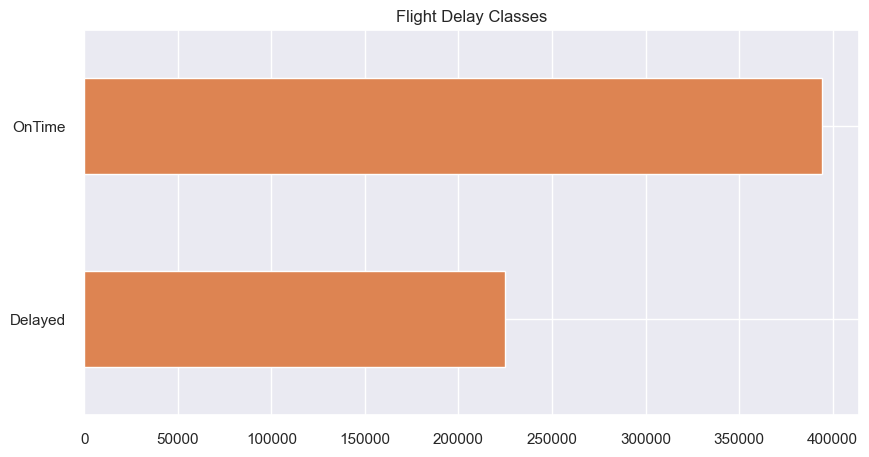

In [20]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

In [21]:
# Is class balanced or imbalanced?
df_flights["DepDelayClass"].value_counts()

OnTime     394411
Delayed    225127
Name: DepDelayClass, dtype: int64

In [22]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619568 entries, 0 to 619567
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FlightDate             619568 non-null  datetime64[ns]
 1   Operating_Airline      619568 non-null  category      
 2   Tail_Number            619568 non-null  category      
 3   Flight_Number          619568 non-null  int16         
 4   OriginAirportID        619568 non-null  int16         
 5   Origin                 619568 non-null  category      
 6   OriginCityName         619568 non-null  category      
 7   OriginState            619568 non-null  category      
 8   OriginStateName        619568 non-null  category      
 9   DestAirportID          619568 non-null  int16         
 10  Dest                   619568 non-null  category      
 11  DestCityName           619568 non-null  category      
 12  DestState              619568 non-null  cate

Feature Analysis
- Feature importance & Selection

In [23]:
#df_flights.columns.to_list()

In [24]:
####Feature Selection#####
ml_cols = [
    #'FlightDate',
    #'Operating_Airline',
    #'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    #'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    #'Cancelled',
    #'CancellationCode',
    #'Diverted',
    #'CRSElapsedTime',
    'AirTime',
    #'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    #'latitude',
    #'longitude',
    #'DepDelayClass',
    'DepDelayClass_ordinal'
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2 = df_flights_2[df_flights_2["DepDelayClass_ordinal"].notna()]
df_flights_2.columns

Index(['Flight_Number', 'OriginAirportID', 'DestAirportID', 'CRSDepTime',
       'DepTime', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'AirTime',
       'TotalAddGTime', 'DepDelayClass_ordinal'],
      dtype='object')

In [25]:
df_flights_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619538 entries, 0 to 619567
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Flight_Number          619538 non-null  int16  
 1   OriginAirportID        619538 non-null  int16  
 2   DestAirportID          619538 non-null  int16  
 3   CRSDepTime             619538 non-null  int16  
 4   DepTime                619538 non-null  float16
 5   TaxiOut                619538 non-null  float16
 6   WheelsOn               619538 non-null  float16
 7   TaxiIn                 619538 non-null  float16
 8   CRSArrTime             619538 non-null  int16  
 9   AirTime                619538 non-null  float16
 10  TotalAddGTime          619538 non-null  float16
 11  DepDelayClass_ordinal  619538 non-null  float16
dtypes: float16(7), int16(5)
memory usage: 18.9 MB


In [26]:
df_flights_2.head()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,AirTime,TotalAddGTime,DepDelayClass_ordinal
0,3300,12953,15096,1810,1805.0,20.0,1907.0,6.0,1928,42.0,0.0,0.0
1,3301,11617,10397,1415,1516.0,12.0,1648.0,11.0,1605,80.0,0.0,1.0
2,3302,10397,11641,1714,1709.0,13.0,1811.0,8.0,1834,49.0,0.0,0.0
3,3303,14492,10721,1420,1416.0,20.0,1606.0,10.0,1619,90.0,0.0,0.0
4,3305,10397,14108,1215,1203.0,12.0,1237.0,7.0,1309,82.0,0.0,0.0


### Model Building
- Model Selection
- Hyperparameter tuning
- Cross validation
- Model Evaluation

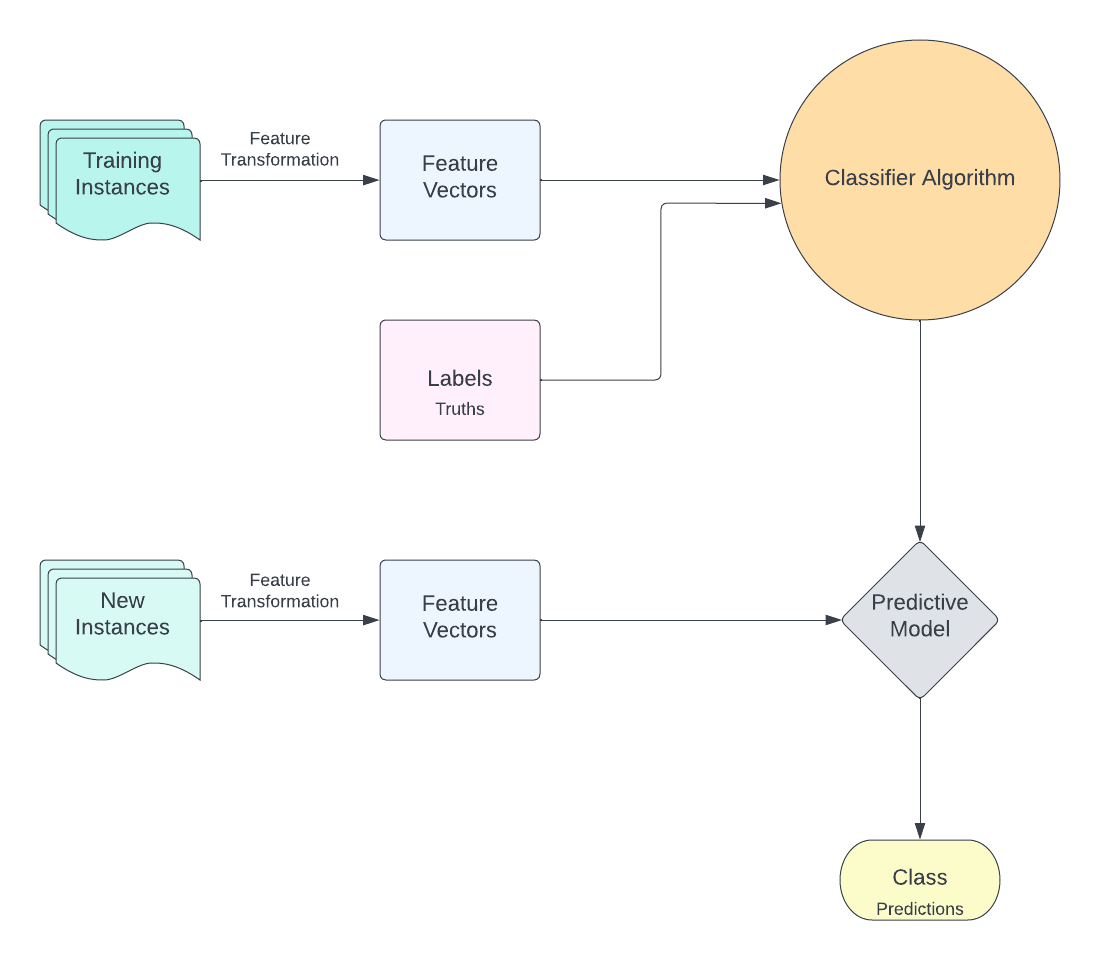

In [28]:
Image("../../../data/images/ModellingWorkflow.png")

Extract independent & dependent variables

In [29]:
#df_flights_2.columns.to_list()

In [30]:
X = df_flights_2[['Flight_Number',
                  'OriginAirportID',
                  'DestAirportID',
                  'CRSDepTime',
                  'DepTime',
                  'TaxiOut',
                  'WheelsOn',
                  'TaxiIn',
                  'CRSArrTime',
                  #'CRSElapsedTime',
                  'AirTime',
                  #'Distance',
                  'TotalAddGTime']] # independent features
y = df_flights_2['DepDelayClass_ordinal'] # dependent feature

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (619538, 11)
y shape: (619538,)


Feature importance

In [31]:
# Check to see if dataset is imbalanced
y.value_counts(dropna=False)

0.0    394411
1.0    225127
Name: DepDelayClass_ordinal, dtype: int64

In [32]:
df_flights_2.dtypes

Flight_Number              int16
OriginAirportID            int16
DestAirportID              int16
CRSDepTime                 int16
DepTime                  float16
TaxiOut                  float16
WheelsOn                 float16
TaxiIn                   float16
CRSArrTime                 int16
AirTime                  float16
TotalAddGTime            float16
DepDelayClass_ordinal    float16
dtype: object

In [33]:
df_flights_2.shape

(619538, 12)

In [34]:
df_flights_2.describe()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,AirTime,TotalAddGTime,DepDelayClass_ordinal
count,619538.000000,619538.000000,619538.000000,619538.000000,619538.0,619538.0,619538.0,619538.0,619538.000000,619538.0,619538.0,619538.0
mean,2687.085483,12678.261212,12682.375825,1328.259919,NaN,NaN,NaN,NaN,1486.529127,NaN,NaN,NaN
std,1835.770148,1522.394466,1522.093185,487.431281,NaN,0.0,NaN,0.0,513.958039,NaN,NaN,0.0
min,1.000000,10135.000000,10135.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
25%,1104.000000,11292.000000,11292.000000,915.000000,859.0,11.0,1030.0,4.0,1103.000000,57.0,0.0,0.0
50%,2291.000000,12889.000000,12889.000000,1320.000000,1313.0,14.0,1448.0,6.0,1514.000000,90.0,0.0,0.0
75%,4234.000000,14057.000000,14057.000000,1732.000000,1736.0,19.0,1903.0,9.0,1917.000000,137.0,0.0,1.0
max,9692.000000,16869.000000,16869.000000,2359.000000,2400.0,176.0,2400.0,248.0,2400.000000,695.0,318.0,1.0


Fit & Evaluate the model 


In [35]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    #kf = KFold(n_splits = 12, shuffle=True)
    ##### StratifiedKFold used to overcome the problem of imbalanced dataset
    skf = StratifiedKFold(n_splits = 12, shuffle=True)
    st_x = StandardScaler()
    
    for train, test in skf.split(X, y):
        X_train, X_test = st_x.fit_transform(X.iloc[train]), st_x.transform(X.iloc[test])
        y_train, y_test = y.iloc[train], y.iloc[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))


KNeighbors Classification
- Requires Standardization because it uses `Euclidean distance` and `Manhattan distance`. Because of this you need to use standardization so that tha computation becomes easy

In [36]:
fit_and_evaluate(X, y, KNeighborsClassifier, "Flight KNeighbors Classifier")

Build and Validation of Flight KNeighbors Classifier took 402.685 seconds
Validation scores are as follows:

precision    0.683628
recall       0.695373
accuracy     0.695373
f1           0.679891
dtype: float64

Fitted model written to:
d:\Georgetown\georgetown_analytics\team-3\flight_model\notebooks\ML_MODELLING\KNeighbors\flight-kneighbors-classifier.pickle


Hyperparameter Tuning
- optimizing hyperparameters to improve the performance of our machine learning models.  
- Gridsearch is a method for finding the best combination of hyperparameters via an exhaustive search over specified parameter values for an estimator.
- When you do a gridsearch, scikit-learn creates a new model for each possible combination of hyperparameters. 
- Each of these combinations is a point on the search grid. 
- Gridsearch trains each of these models and evaluates them using cross-validation, and then provides the results for the one that performed best.

GridSearchCV

In [ ]:
def grid_and_search(X, y, model, parameters, **kwargs):
    start = time.time()  # Start the clock!
    scores = {'precision': [], 'recall': [], 'accuracy': [], 'f1': []}

    #kf = KFold(n_splits = 12, shuffle=True)
    # StratifiedKFold used to overcome the problem of imbalanced dataset
    skf = StratifiedKFold(n_splits=12, shuffle=True)
    st_x = StandardScaler()

    for train, test in skf.split(X, y):
        X_train, X_test = st_x.fit_transform(
            X.iloc[train]), st_x.transform(X.iloc[test])
        y_train, y_test = y.iloc[train], y.iloc[test]

        estimator = model(**kwargs)

        grid_search = GridSearchCV(estimator=estimator,
                                   param_grid=parameters,
                                   scoring='accuracy',
                                   cv=10,
                                   n_jobs=-1,
                                   verbose=True)

        # fitting the model for grid search
        grid_search = grid_search.fit(X_train, y_train)

        # print best parameter after tuning
        print(grid_search.best_params_)
        
        grid_predictions = grid_search.predict(X_test)
        
        # print confusion matrix
        print(confusion_matrix(y_test, grid_predictions))

        # print classification report
        print(classification_report(y_test, grid_predictions))

In [ ]:
# Applying Grid Search to find the best model and the best parameters
parameters = {
    #TODO
}

grid_and_search(X, y, KNeighborsClassifier, parameters)